In [1]:
from trans import Dataset
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = Dataset('data/transcriptions/train.csv')
words_vocab = data.words_vocab
trans_vocab = data.trans_vocab

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=5000):
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp((torch.arange(0, dim, 2, dtype=torch.float) *
                             -(math.log(10000.0) / dim)))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(0)
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pe', pe)
        self.dim = dim

    def forward(self, emb):
        emb = emb * math.sqrt(self.dim)
        emb = emb + self.pe[:,:emb.size(1),:]
        return emb

In [5]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, num_heads, model_size):
        super(MultiHeadAttention, self).__init__()
        
        assert model_size % num_heads == 0 
        
        self.model_size = model_size
        self.num_heads = num_heads
        self.head_size    = model_size // num_heads
        
        self.linear_query = nn.Linear(model_size, model_size, bias = False)
        self.linear_key   = nn.Linear(model_size, model_size, bias = False)
        self.linear_value = nn.Linear(model_size, model_size, bias = False)
        self.linear_out = nn.Linear(model_size, model_size, bias = False)
        
    def forward(self, query, key, value, mask):
        '''
        Inputs:
            query:   (batch, target_len, hidden)
            key:     (batch, source_len, hidden)
            value:   (batch, source_len, hidden)  
            mask:    (batch, target_len, source_len)

        Outputs:
            output:  (batch, target_len, model_size)
            weight:  (batch, num_heads, target_len, source_len)
        '''
        batch_size = query.size(0)        
        
        query = self.linear_query(query)
        key   = self.linear_key(key)
        value = self.linear_value(value)
      
        query = query.view(batch_size, -1, self.num_heads, self.head_size)
        key   = key.view(batch_size, -1, self.num_heads, self.head_size)
        value = value.view(batch_size, -1, self.num_heads, self.head_size)
        
        query = query.transpose(1, 2)
        key = key.transpose(1, 2)
        value = value.transpose(1, 2)
             
        key = key.transpose(2, 3)
        
        logits = torch.matmul(query, key)
        logits = logits / math.sqrt(self.head_size)

        
        if mask is not None:
            mask = mask.unsqueeze(1)#.repeat()
            logits.masked_fill_(mask, -1e18)      
        
        weights = F.softmax(logits, dim = -1)

        output = torch.matmul(weights, value)       
        output = output.transpose(1,2).contiguous()
        output = output.view(batch_size, -1, self.model_size)
        output = self.linear_out(output)

        return output, weights

In [6]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, model_size, ff_size):
        super(PositionWiseFeedForward, self).__init__()
        
        self.linear_1 = nn.Linear(model_size, ff_size)
        self.linear_2 = nn.Linear(ff_size, model_size)
        self.layer_norm = nn.LayerNorm(model_size)
        
    def forward(self, x):
        '''
        Inputs:
            x: (batch_size x seq_len x model-size)
        Outputs:
            output: 
        '''        
        res = x
        x = self.layer_norm(x)
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)
        
        return x + res

### Encoder part

In [7]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, model_size, num_heads, ff_size):
        super(TransformerEncoderLayer, self).__init__()
        
        self.self_attention = MultiHeadAttention(num_heads, model_size)
        self.positionwise_ff = PositionWiseFeedForward(model_size, ff_size)
        self.layer_norm = nn.LayerNorm(model_size)
        
    def forward(self, x, mask=None):
        '''
        Inputs:
            x: (batch x seq_len x model_size)
            mask: (batch x seq_len x seq_len)
            
        Outputs:
            output : (batch x seq_len, model_size)
        '''
        
        res  = x
        x, _ = self.self_attention(x, x, x, mask)       
        x    = x + res
        x    = self.positionwise_ff(x)
        x    = self.layer_norm(x)
        
        
        return x        

In [8]:
class TransformerEncoder(nn.Module):
    def __init__(self, 
                vocab_size,
                num_layers, 
                model_size, 
                num_heads,
                ff_size,
                padding_idx):
        super(TransformerEncoder, self).__init__()
        
        self.padding_idx = padding_idx

        self.embedding = nn.Embedding(vocab_size, model_size, padding_idx=padding_idx)
    
        self.positional_enc = PositionalEncoding(model_size)

        self.enc_blocks = nn.ModuleList(
                            [TransformerEncoderLayer(model_size, num_heads, ff_size)
                                        for _ in range(num_layers)])
        
    def forward(self, source):
        
        '''
        Inputs: 
            source: (batch_size, source_len)
            
        Outputs:
            x: (batch, source_len, hidden)
        '''
        source_mask = source == self.padding_idx
        mask = (source == self.padding_idx).unsqueeze(1).repeat(1, source.size(1), 1)

        source_emb = self.embedding(source)
        source_emb = self.positional_enc(source_emb)
        
        x = source_emb
        for layer in self.enc_blocks:       
            x = layer(x, mask)

        return x, source_mask   

In [9]:
class DecoderCell(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, pad_idx):
        super(DecoderCell, self).__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)

        self.GRU_cell = nn.GRUCell(emb_size, hidden_size)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        self.attention = DotAttentionNoCell()
        
    def forward(self, hidden, target, mask = None):
        
        embedded = self.embedding(target)

        hidden = self.GRU_cell(embedded, hidden)
        
        out = self.linear(hidden)
        
        return out, hidden

### Decoder part


In [10]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, model_size, num_heads, ff_size):
        super(TransformerDecoderLayer, self).__init__()
        
        self.self_attention = MultiHeadAttention(num_heads, model_size)
        self.positionwise_ff = PositionWiseFeedForward(model_size, ff_size)
        self.layer_norm = nn.LayerNorm(model_size)
        
    def forward(self, x, enc_outputs, enc_mask=None, subseq_mask=None):
        '''
        Inputs:
            x: (batch x target_len x model_size)
            enc_outputs: (batch x num_heads x model_size)
            enc_mask : (batch x target_len x source_len)
            subseq_mask: (batch x target_len x target_len)
            
        Outputs:
            output : (batch x ? x ?)
        '''      
        res  = x
        
        x, _ = self.self_attention(x, x, x, subseq_mask)     
        x    = x + res       
        x    = self.layer_norm(x)       
        
        res2 = x      
        #enc_mask = enc_mask.unsqueeze(1).repeat(1, res.size(1), 1)
        x, _ = self.self_attention(x, enc_outputs, enc_outputs, enc_mask)
        
        x = res2 + x        
        x = self.positionwise_ff(x)        
        x = self.layer_norm(x)        
        
        return x        

In [11]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, num_layers, pad_idx):
        super(TransformerDecoder, self).__init__()
        
        self.padding_idx = pad_idx
        
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        
        self.positional_enc = PositionalEncoding(hidden_size)
        
        self.dec_blocks = nn.ModuleList(
                            [TransformerDecoderLayer(hidden_size, num_heads, ff_size)
                                        for _ in range(num_layers)])
        self.linear_out = nn.Linear(hidden_size, vocab_size, bias = False)   
        
    def forward(self, target, enc_outputs, batch_words, val=False):        
        '''
        Inputs: 
            source: (batch_size, target_len)
            
        Outputs:
            x: (batch, source_len, hidden)
        '''

        batch_size, target_len = target.size()
        
        subseq_mask = torch.triu(
                torch.ones((target_len, target_len), device=target.device, dtype=torch.uint8), diagonal=1)
        subseq_mask = subseq_mask.unsqueeze(0).expand(batch_size, -1, -1)  # b x ls x ls
        
        dec_mask_ = (target == 0).unsqueeze(1).repeat(1, target_len, 1)
        
        dec_mask = (subseq_mask + dec_mask_).gt(0)
        
        target_emb = self.embedding(target)
        target_emb = self.positional_enc(target_emb) 
        
        
        enc_mask = batch_words == 0
        enc_mask = enc_mask.unsqueeze(1).repeat(1, target_len, 1)
        x = target_emb
        for layer in self.dec_blocks:       
            x = layer(x, enc_outputs, enc_mask, dec_mask)            
        
        
        logits = self.linear_out(x)
        
        logits = logits.view(-1, self.vocab_size)
        
        #out = F.softmax(logits)
        
        return logits

### Model

In [12]:
class Model(nn.Module):
    def __init__(self, dataset, encoder, decoder, hidden_size):
        super(Model, self).__init__()
        self.dataset = dataset
        self.encoder = encoder
        self.decoder = decoder
        
        
    def forward(self, batch_words, batch_trans_in, source_lens = None, mask = None):
        
        enc_outputs, _ = self.encoder(batch_words)
        out = self.decoder(batch_trans_in, enc_outputs, batch_words, False)
        
        return out

In [13]:
def generate(model, bos_idx, eos_idx, batch_words):
        inp = [bos_idx]
        enc_outputs, enc_mask = model.encoder(batch_words)
        
        
        for _ in range(100):
            inp_tensor = torch.LongTensor([inp]).to(batch_words.device)
            logits = model.decoder(inp_tensor, enc_outputs, batch_words, True)
            next_token = F.softmax(logits, dim=-1)[-1].topk(1)[1].item()
            inp.append(next_token)
            if next_token == eos_idx:
                break
        return inp

In [14]:
def translate(model, sos_idx, eos_idx, batch_words):
        '''
        Inputs:
            batch_words: (1 x seq_len)
        Outputs:
            tokens: example - [45, 30, 122, 4, 8, 5]
        '''
        outputs, _ = model.encoder(batch_words)
        generated_word = [sos_idx]
        seq_len = batch_words.size(1)
        
        for char in range(seq_len):
            inp_tensor = torch.LongTensor([generated_word]).to(device)
            logits = model.decoder(inp_tensor, outputs, batch_words.to(device))

            #logits = logits.squeeze(0)
            
            logits = F.softmax(logits, dim=-1)
            prob_next_token, next_token = logits[-1, :].max(0)
            generated_word.append(next_token.item())
            if next_token is eos_idx:
                break
        return generated_word

In [15]:
hidden_size = 256
num_heads   = 8
num_layers = 2
ff_size = 128

encoder = TransformerEncoder(len(words_vocab), num_layers, 
                hidden_size, 
                num_heads,
                ff_size,
                0).to(device)

decoder = TransformerDecoder(len(trans_vocab), hidden_size, hidden_size, num_layers, 0).to(device)

criterion = nn.CrossEntropyLoss()
model = Model(data, encoder, decoder, hidden_size).to(device)
optimizer = optim.Adam(model.parameters())

In [19]:
class Trainer:
    def __init__(self, dataset, model, optimizer, criterion, batch_size):
        
        
        self.dataset = dataset
        self.train_losses = []
        self.val_losses = []
        self.batch_size = batch_size
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        
               
    def train(self, n_epochs):
        
        mask_words = None
        for epoch in range(n_epochs):

            for batch_idx in range(len(self.dataset)//self.batch_size):

                batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = self.dataset.get_batch(32, sort = True)
                mask_words  = batch_words != 0
                
                logits = self.model(batch_words, batch_trans_in, words_lens, mask_words)

                batch_trans_out = batch_trans_out.view(-1)  
                mask = batch_trans_out != self.dataset.trans_vocab.pad_idx
                
                print(logits.shape)
                print(batch_trans_out.shape)
                loss = self.criterion(logits[mask], batch_trans_out[mask])

                self.optimizer.zero_grad()

                loss.backward()

                self.optimizer.step()


                self.train_losses.append(loss.item())
                
                if batch_idx % 200 == 0:
                    val_loss = self.eval_()
                    self.val_losses.append(val_loss.item())
                    self.plot(epoch, batch_idx, self.train_losses, self.val_losses)
                  
        
    def eval_(self):
        
        val_words, val_trans_in, val_trans_out, val_words_lens, val_trans_lens = self.dataset.get_batch(32, sort = True, val = True)
        val_mask = val_words != 0
        logits = self.model(val_words, val_trans_in, val_words_lens, val_mask)
        val_trans_out = val_trans_out.view(-1)                

        mask = val_trans_out != trans_vocab.pad_idx

        loss = self.criterion(logits[mask], val_trans_out[mask])

        return loss
        
    def plot(self, epoch, batch_idx, train_losses, val_losses):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('epoch %s. | batch: %s | loss: %s' % (epoch, batch_idx, train_losses[-1]))
        plt.plot(train_losses)
        plt.subplot(132)
        plt.title('epoch %s. | loss: %s' % (epoch, val_losses[-1]))
        plt.plot(val_losses)
        plt.show()  

In [20]:
trainer = Trainer(data, model, optimizer, criterion, batch_size = 32)

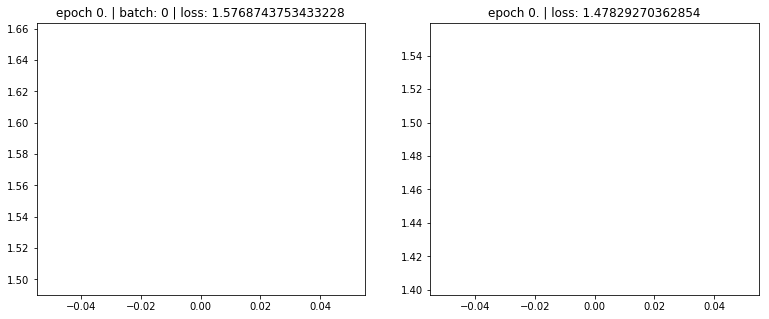

torch.Size([320, 44])
torch.Size([320])
torch.Size([448, 44])
torch.Size([448])
torch.Size([480, 44])
torch.Size([480])
torch.Size([544, 44])
torch.Size([544])
torch.Size([352, 44])
torch.Size([352])
torch.Size([352, 44])
torch.Size([352])
torch.Size([352, 44])
torch.Size([352])
torch.Size([448, 44])
torch.Size([448])
torch.Size([448, 44])
torch.Size([448])
torch.Size([448, 44])
torch.Size([448])
torch.Size([384, 44])
torch.Size([384])
torch.Size([480, 44])
torch.Size([480])
torch.Size([384, 44])
torch.Size([384])
torch.Size([384, 44])
torch.Size([384])
torch.Size([320, 44])
torch.Size([320])
torch.Size([352, 44])
torch.Size([352])
torch.Size([320, 44])
torch.Size([320])
torch.Size([384, 44])
torch.Size([384])
torch.Size([416, 44])
torch.Size([416])
torch.Size([448, 44])
torch.Size([448])
torch.Size([416, 44])
torch.Size([416])
torch.Size([384, 44])
torch.Size([384])
torch.Size([448, 44])
torch.Size([448])
torch.Size([352, 44])
torch.Size([352])
torch.Size([320, 44])
torch.Size([320])


KeyboardInterrupt: 

In [21]:
trainer.train(10)

In [ ]:
def _print(val, model):
    batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = data.get_batch(1, sort=True, val=val)
    batch_words     = batch_words.to(device)
    batch_trans_out = batch_trans_out.to(device)


    inp = translate(model, data.words_vocab.sos_idx, data.words_vocab.eos_idx, batch_words)
            
    tokens = [data.trans_vocab.idx2token(idx) for idx in inp if idx not in [data.trans_vocab.sos_idx,
                                                                       data.trans_vocab.eos_idx,
                                                                       data.trans_vocab.pad_idx]]
    print('Src: ', ''.join([data.words_vocab.idx2token(idx) for idx in batch_words[0].tolist()]))
    print('Pred:', ''.join(tokens))
    print('Real:', ''.join([data.trans_vocab.idx2token(idx) for idx in batch_trans_out[0].tolist() if idx not in [data.trans_vocab.sos_idx,
                                                                            data.trans_vocab.eos_idx,
                                                                            data.trans_vocab.pad_idx]]))

In [ ]:
for _ in range(10):
    _print(True, model)
    print()